# fit animal by animal

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from scipy.integrate import quad
import pandas as pd

from pyvbmc import VBMC
import random
import os
from tqdm import tqdm
from time_vary_norm_utils import (
    up_or_down_RTs_fit_fn, cum_pro_and_reactive_time_vary_fn,
    rho_A_t_VEC_fn, up_or_down_RTs_fit_wrt_stim_fn, rho_A_t_fn, cum_A_t_fn)
import corner
from scipy.integrate import trapezoid as trapz
from time_vary_and_norm_simulators import psiam_tied_data_gen_wrapper_rate_norm_fn
from scipy.integrate import cumulative_trapezoid as cumtrapz
from time_vary_norm_utils import up_or_down_RTs_fit_PA_C_A_given_wrt_t_stim_fn

In [56]:
### Read csv and get batch data###
exp_df = pd.read_csv('../outExp.csv')

exp_df = exp_df[~((exp_df['RTwrtStim'].isna()) & (exp_df['abort_event'] == 3))].copy()

exp_df_batch = exp_df[
    (exp_df['batch_name'] == 'Comparable') &
    (exp_df['LED_trial'].isin([np.nan, 0]))
].copy()

exp_df_batch['choice'] = exp_df_batch['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))
# 1 or 0 if the choice was correct or not
exp_df_batch['accuracy'] = (exp_df_batch['ILD'] * exp_df_batch['choice']).apply(lambda x: 1 if x > 0 else 0)

In [57]:
### DF - valid and aborts ###
df_valid_and_aborts = exp_df_batch[
    (exp_df_batch['success'].isin([1,-1])) |
    (exp_df_batch['abort_event'] == 3)
].copy()

df_aborts = df_valid_and_aborts[df_valid_and_aborts['abort_event'] == 3]

### Animal selection ###
animal_ids = df_valid_and_aborts['animal'].unique()
animal = animal_ids[-1]

df_all_trials_animal = df_valid_and_aborts[df_valid_and_aborts['animal'] == animal]
df_aborts_animal = df_aborts[df_aborts['animal'] == animal]

print(f'sample animal: {animal}')

# find ABL and ILD
ABL_arr = df_valid_and_aborts['ABL'].unique()
ILD_arr = df_valid_and_aborts['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

sample animal: 41
ABL: [10 25 40 50 55 70]
ILD: [-8.   -4.   -2.25 -1.25 -0.5   0.    0.5   1.25  2.25  4.    8.  ]


In [4]:
T_trunc = 0.3

In [5]:
def compute_loglike_aborts(row, V_A, theta_A, t_A_aff, pdf_trunc_factor):
    t_stim = row['intended_fix']
    rt = row['TotalFixTime']

    if rt < T_trunc:
        likelihood = 0
    else:
        if rt < t_stim:
            likelihood =  rho_A_t_fn(rt - t_A_aff, V_A, theta_A) / pdf_trunc_factor
        elif rt > t_stim:
            if t_stim <= T_trunc:
                likelihood = 1
            else:
                likelihood = ( 1 - cum_A_t_fn(t_stim - t_A_aff, V_A, theta_A) ) / pdf_trunc_factor

    if likelihood <= 0:
        likelihood = 1e-50

    if np.isnan(likelihood):
        print(f'likelihood is nan for rt={rt}, t_stim={t_stim}, t_A_aff={t_A_aff}, pdf_trunc_factor={pdf_trunc_factor}')
        print(f'rho_A_t_fn(rt - t_A_aff, V_A, theta_A) = {rho_A_t_fn(rt - t_A_aff, V_A, theta_A)}')
        print(f'pdf_trunc_factor = {pdf_trunc_factor}')
        print(f'cum_A_t_fn(t_stim - t_A_aff, V_A, theta_A) = {cum_A_t_fn(t_stim - t_A_aff, V_A, theta_A)}')
        raise ValueError('likelihood is nan')

    
    return np.log(likelihood)    



def vbmc_aborts_loglike_fn(params):
    V_A, theta_A, t_A_aff = params

    pdf_trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff, V_A, theta_A)
    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike_aborts)(row, V_A, theta_A, t_A_aff, pdf_trunc_factor) \
                                       for _, row in df_all_trials_animal.iterrows()  )
                                   


    loglike = np.sum(all_loglike)
    return loglike

In [6]:
V_A_bounds = [0.1, 10]
theta_A_bounds = [0.1, 10]
t_A_aff_bounds = [-5, 0.1]

V_A_plausible_bounds = [0.5, 3]
theta_A_plausible_bounds = [0.5, 3]
t_A_aff_plausible_bounds = [-2, 0.06]

In [7]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    V_A, theta_A,t_A_aff = params

    V_A_logpdf = trapezoidal_logpdf(V_A, V_A_bounds[0], V_A_plausible_bounds[0], V_A_plausible_bounds[1], V_A_bounds[1])
    theta_A_logpdf = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])
    t_A_aff_logpdf = trapezoidal_logpdf(t_A_aff, t_A_aff_bounds[0], t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1], t_A_aff_bounds[1])
    return V_A_logpdf + theta_A_logpdf + t_A_aff_logpdf

In [8]:
def vbmc_joint_aborts_fn(params):
    return vbmc_prior_abort_fn(params) + vbmc_aborts_loglike_fn(params)

In [9]:
lb = [V_A_bounds[0], theta_A_bounds[0], t_A_aff_bounds[0]]
ub = [V_A_bounds[1], theta_A_bounds[1], t_A_aff_bounds[1]]


plb = [V_A_plausible_bounds[0], theta_A_plausible_bounds[0], t_A_aff_plausible_bounds[0]]
pub = [V_A_plausible_bounds[1], theta_A_plausible_bounds[1], t_A_aff_plausible_bounds[1]]

np.random.seed(42)
V_A_0 = np.random.uniform(V_A_plausible_bounds[0], V_A_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])
t_A_aff_0 = np.random.uniform(t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1])

x_0 = np.array([V_A_0, theta_A_0, t_A_aff_0])


In [10]:
vbmc = VBMC(vbmc_joint_aborts_fn, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10     -126129.18       118.81 136108285.28        2        inf     start warm-up
     1         15     -125996.88        49.80       738.96        2        inf     
     2         20     -126098.71        46.93       356.52        2   7.36e+03     
     3         25     -125946.61        62.38       225.29        2   5.05e+03     
     4         30     -125790.04        81.08      2093.07        2   4.11e+04     
     5         35     -125376.36       216.73      1597.18        2   3.28e+04     
     6         40     -125458.22       176.98       377.83        2   8.13e+03     
     7         45     -125526.19         3.7

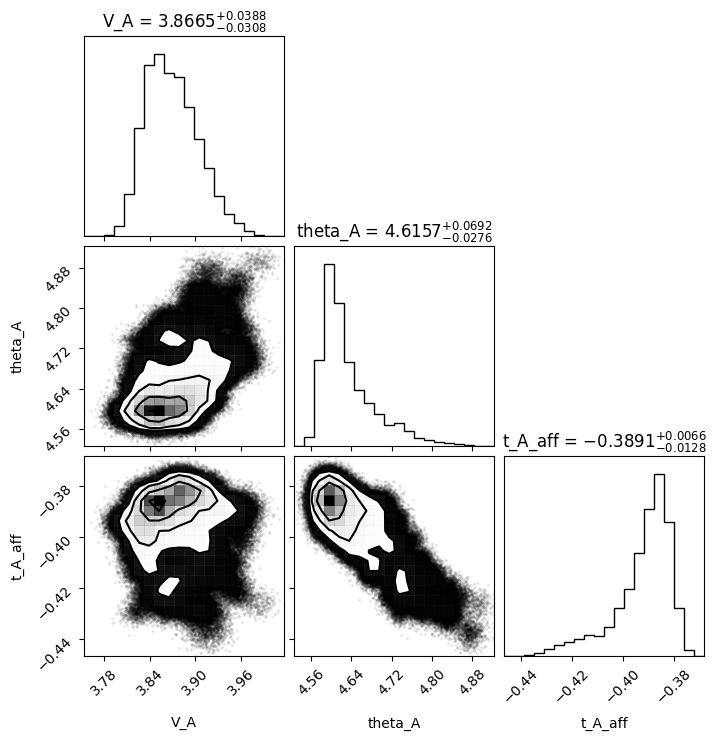

In [14]:
vp_samples = vp.sample(int(1e6))[0]
V_A_samp = vp_samples[:,0]
theta_A_samp = vp_samples[:,1]
t_A_aff_samp = vp_samples[:,2]

combined_samples = np.transpose(np.vstack((V_A_samp, theta_A_samp, t_A_aff_samp)))
param_labels = ['V_A', 'theta_A', 't_A_aff']
corner.corner (combined_samples, labels=param_labels, show_titles=True, title_fmt=".4f" );


In [15]:
V_A = vp_samples[:,0].mean()
theta_A = vp_samples[:,1].mean()
t_A_aff = vp_samples[:,2].mean()


print(f'V_A: {V_A}')
print(f'theta_A: {theta_A}')
print(f't_A_aff: {t_A_aff}')

V_A: 3.869828186286512
theta_A: 4.633338027222355
t_A_aff: -0.3920603686184358


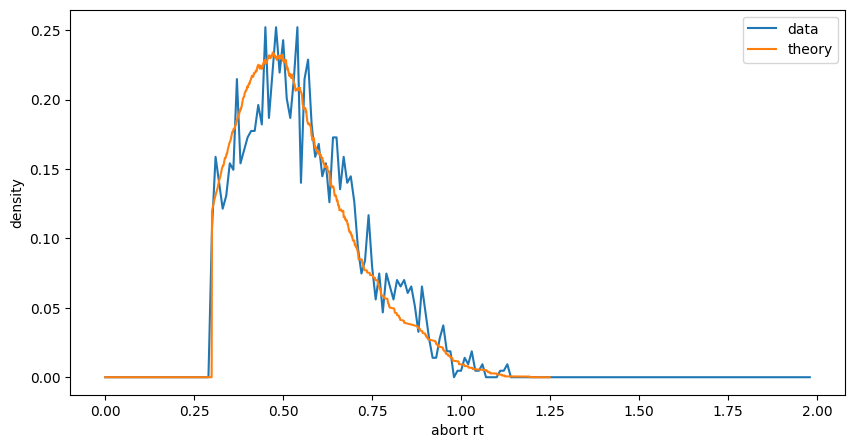

In [19]:


N_theory = int(1e3)
t_pts = np.arange(0,1.25, 0.001)
t_stim_samples = df_valid_and_aborts.sample(N_theory)['intended_fix']
pdf_samples = np.zeros((N_theory, len(t_pts)))
proactive_trunc_time = T_trunc

for i, t_stim in enumerate(t_stim_samples):
    t_stim_idx = np.searchsorted(t_pts, t_stim)
    proactive_trunc_idx = np.searchsorted(t_pts, proactive_trunc_time)
    pdf_samples[i, :proactive_trunc_idx] = 0
    pdf_samples[i, t_stim_idx:] = 0
    t_btn = t_pts[proactive_trunc_idx:t_stim_idx-1]
    
    pdf_samples[i, proactive_trunc_idx:t_stim_idx-1] = rho_A_t_VEC_fn(t_btn - t_A_aff, V_A, theta_A) / (1 - cum_A_t_fn(proactive_trunc_time - t_A_aff, V_A, theta_A))



plt.figure(figsize=(10,5))

bins = np.arange(0,2,0.01)

# df_aborts_RT = df_aborts['TotalFixTime'].dropna().values
animal_abort_RT = df_aborts_animal['TotalFixTime'].dropna().values
animal_abort_RT_trunc = animal_abort_RT[animal_abort_RT > T_trunc]

df_before_trunc_animal = df_aborts_animal[df_aborts_animal['TotalFixTime'] < T_trunc]
N_valid_and_trunc_aborts = len(df_all_trials_animal) - len(df_before_trunc_animal)
frac_aborts = len(animal_abort_RT_trunc) / N_valid_and_trunc_aborts
aborts_hist, _ = np.histogram(animal_abort_RT_trunc, bins=bins, density=True)

plt.plot(bins[:-1], aborts_hist * frac_aborts, label='data')
plt.xlabel('abort rt')
plt.ylabel('density')

plt.plot(t_pts, np.mean(pdf_samples, axis=0), label='theory')
plt.legend()

# valid trials

## vanilla model

In [20]:
is_norm = False
is_time_vary = False
phi_params_obj = np.nan
rate_norm_l = np.nan

proactive_trunc_time = 0.3
K_max = 10

In [58]:
# df_all_trials_animal
df_valid_animal = df_all_trials_animal[df_all_trials_animal['success'].isin([1,-1])]
df_valid_animal_less_than_1 = df_valid_animal[df_valid_animal['RTwrtStim'] < 1]

In [32]:
def compute_loglike_vanilla(row, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go):
    
    rt = row['TotalFixTime']
    t_stim = row['intended_fix']
    
    
    ILD = row['ILD']
    ABL = row['ABL']
    choice = row['choice']

    pdf = up_or_down_RTs_fit_fn(
            rt, choice,
            V_A, theta_A, t_A_aff,
            t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
            phi_params_obj, rate_norm_l, 
            is_norm, is_time_vary, K_max)

    trunc_factor_p_joint = cum_pro_and_reactive_time_vary_fn(
                            t_stim + 1, proactive_trunc_time,
                            V_A, theta_A, t_A_aff,
                            t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                            phi_params_obj, rate_norm_l, 
                            is_norm, is_time_vary, K_max) \
                            - \
                            cum_pro_and_reactive_time_vary_fn(
                            t_stim, proactive_trunc_time,
                            V_A, theta_A, t_A_aff,
                            t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                            phi_params_obj, rate_norm_l, 
                            is_norm, is_time_vary, K_max)
                           

    pdf /= (trunc_factor_p_joint + 1e-20)
    pdf = max(pdf, 1e-50)
    if np.isnan(pdf):
        print(f'row["abort_event"] = {row["abort_event"]}')
        print(f'row["RTwrtStim"] = {row["RTwrtStim"]}')
        raise ValueError(f'nan pdf rt = {rt}, t_stim = {t_stim}')
    return np.log(pdf)
    
    


def vbmc_vanilla_tied_loglike_fn(params):
    rate_lambda, T_0, theta_E, w, t_E_aff, del_go = params
    Z_E = (w - 0.5) * 2 * theta_E
    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike_vanilla)(row, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go)\
                                       for _, row in df_valid_animal_less_than_1.iterrows() )
    return np.sum(all_loglike)


In [33]:
rate_lambda_bounds = [0.01, 1]
T_0_bounds = [0.1e-3, 2.2e-3]
theta_E_bounds = [5, 65]
w_bounds = [0.3, 0.7]
t_E_aff_bounds = [0.01, 0.2]
del_go_bounds = [0, 0.2]


rate_lambda_plausible_bounds = [0.1, 0.3]
T_0_plausible_bounds = [0.5e-3, 1.5e-3]
theta_E_plausible_bounds = [15, 55]
w_plausible_bounds = [0.4, 0.6]
t_E_aff_plausible_bounds = [0.03, 0.09]
del_go_plausible_bounds = [0.05, 0.15]

In [34]:
def vbmc_vanilla_tied_prior_fn(params):
    rate_lambda, T_0, theta_E, w, t_E_aff, del_go = params

    rate_lambda_logpdf = trapezoidal_logpdf(
        rate_lambda,
        rate_lambda_bounds[0],
        rate_lambda_plausible_bounds[0],
        rate_lambda_plausible_bounds[1],
        rate_lambda_bounds[1]
    )
    
    T_0_logpdf = trapezoidal_logpdf(
        T_0,
        T_0_bounds[0],
        T_0_plausible_bounds[0],
        T_0_plausible_bounds[1],
        T_0_bounds[1]
    )
    
    theta_E_logpdf = trapezoidal_logpdf(
        theta_E,
        theta_E_bounds[0],
        theta_E_plausible_bounds[0],
        theta_E_plausible_bounds[1],
        theta_E_bounds[1]
    )
    
    w_logpdf = trapezoidal_logpdf(
        w,
        w_bounds[0],
        w_plausible_bounds[0],
        w_plausible_bounds[1],
        w_bounds[1]
    )
    
    t_E_aff_logpdf = trapezoidal_logpdf(
        t_E_aff,
        t_E_aff_bounds[0],
        t_E_aff_plausible_bounds[0],
        t_E_aff_plausible_bounds[1],
        t_E_aff_bounds[1]
    )
    
    del_go_logpdf = trapezoidal_logpdf(
        del_go,
        del_go_bounds[0],
        del_go_plausible_bounds[0],
        del_go_plausible_bounds[1],
        del_go_bounds[1]
    )
    
    return (
        rate_lambda_logpdf +
        T_0_logpdf +
        theta_E_logpdf +
        w_logpdf +
        t_E_aff_logpdf +
        del_go_logpdf
    )

In [35]:
def vbmc_vanilla_tied_joint_fn(params):
    priors = vbmc_vanilla_tied_prior_fn(params)
    loglike = vbmc_vanilla_tied_loglike_fn(params)

    return priors + loglike

In [36]:
# Add bounds for all parameters (order: V_A, theta_A, t_A_aff, rate_lambda, T_0, theta_E, w, t_E_aff, del_go)
lb = np.array([
    rate_lambda_bounds[0],
    T_0_bounds[0],
    theta_E_bounds[0],
    w_bounds[0],
    t_E_aff_bounds[0],
    del_go_bounds[0]
])

ub = np.array([
    rate_lambda_bounds[1],
    T_0_bounds[1],
    theta_E_bounds[1],
    w_bounds[1],
    t_E_aff_bounds[1],
    del_go_bounds[1]
])

plb = np.array([
    rate_lambda_plausible_bounds[0],
    T_0_plausible_bounds[0],
    theta_E_plausible_bounds[0],
    w_plausible_bounds[0],
    t_E_aff_plausible_bounds[0],
    del_go_plausible_bounds[0]
])

pub = np.array([
    rate_lambda_plausible_bounds[1],
    T_0_plausible_bounds[1],
    theta_E_plausible_bounds[1],
    w_plausible_bounds[1],
    t_E_aff_plausible_bounds[1],
    del_go_plausible_bounds[1]
])

# Initialize with random values within plausible bounds
np.random.seed(42)
# rate_lambda_0 = np.random.uniform(*rate_lambda_plausible_bounds)
# T_0_0 = np.random.uniform(*T_0_plausible_bounds)
# theta_E_0 = np.random.uniform(*theta_E_plausible_bounds)
# w_0 = np.random.uniform(*w_plausible_bounds)
# t_E_aff_0 = np.random.uniform(*t_E_aff_plausible_bounds)
# del_go_0 = np.random.uniform(*del_go_plausible_bounds)

rate_lambda_0 = 0.17
T_0_0 = 1.5 * 1e-3
theta_E_0 = 20
w_0 = 0.51
t_E_aff_0 = 0.071
del_go_0 = 0.19

x_0 = np.array([
    rate_lambda_0,
    T_0_0,
    theta_E_0,
    w_0,
    t_E_aff_0,
    del_go_0
])

# Run VBMC
vbmc = VBMC(vbmc_vanilla_tied_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 6).
Reshaping upper bounds to (1, 6).
Reshaping plausible lower bounds to (1, 6).
Reshaping plausible upper bounds to (1, 6).
vbmc:InitialPointsOutsidePB. The starting points X0 are not inside the provided plausible bounds PLB and PUB. Expanding the plausible bounds...
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10        6902.73      1060.12          inf        2        inf     start warm-up
     1         15        1176.71      3490.10      9329.39        2        inf     
     2         20        5230.31      1644.16       749.05        2   2.92e+04     
     3         25        7668.22      2233.23     29156.13        2   4.12e+05     
     4         30        5912.01      1606.52      7720.31        2   1.16e+05     
     5         35        6049.99       313.40      1489.31        2 

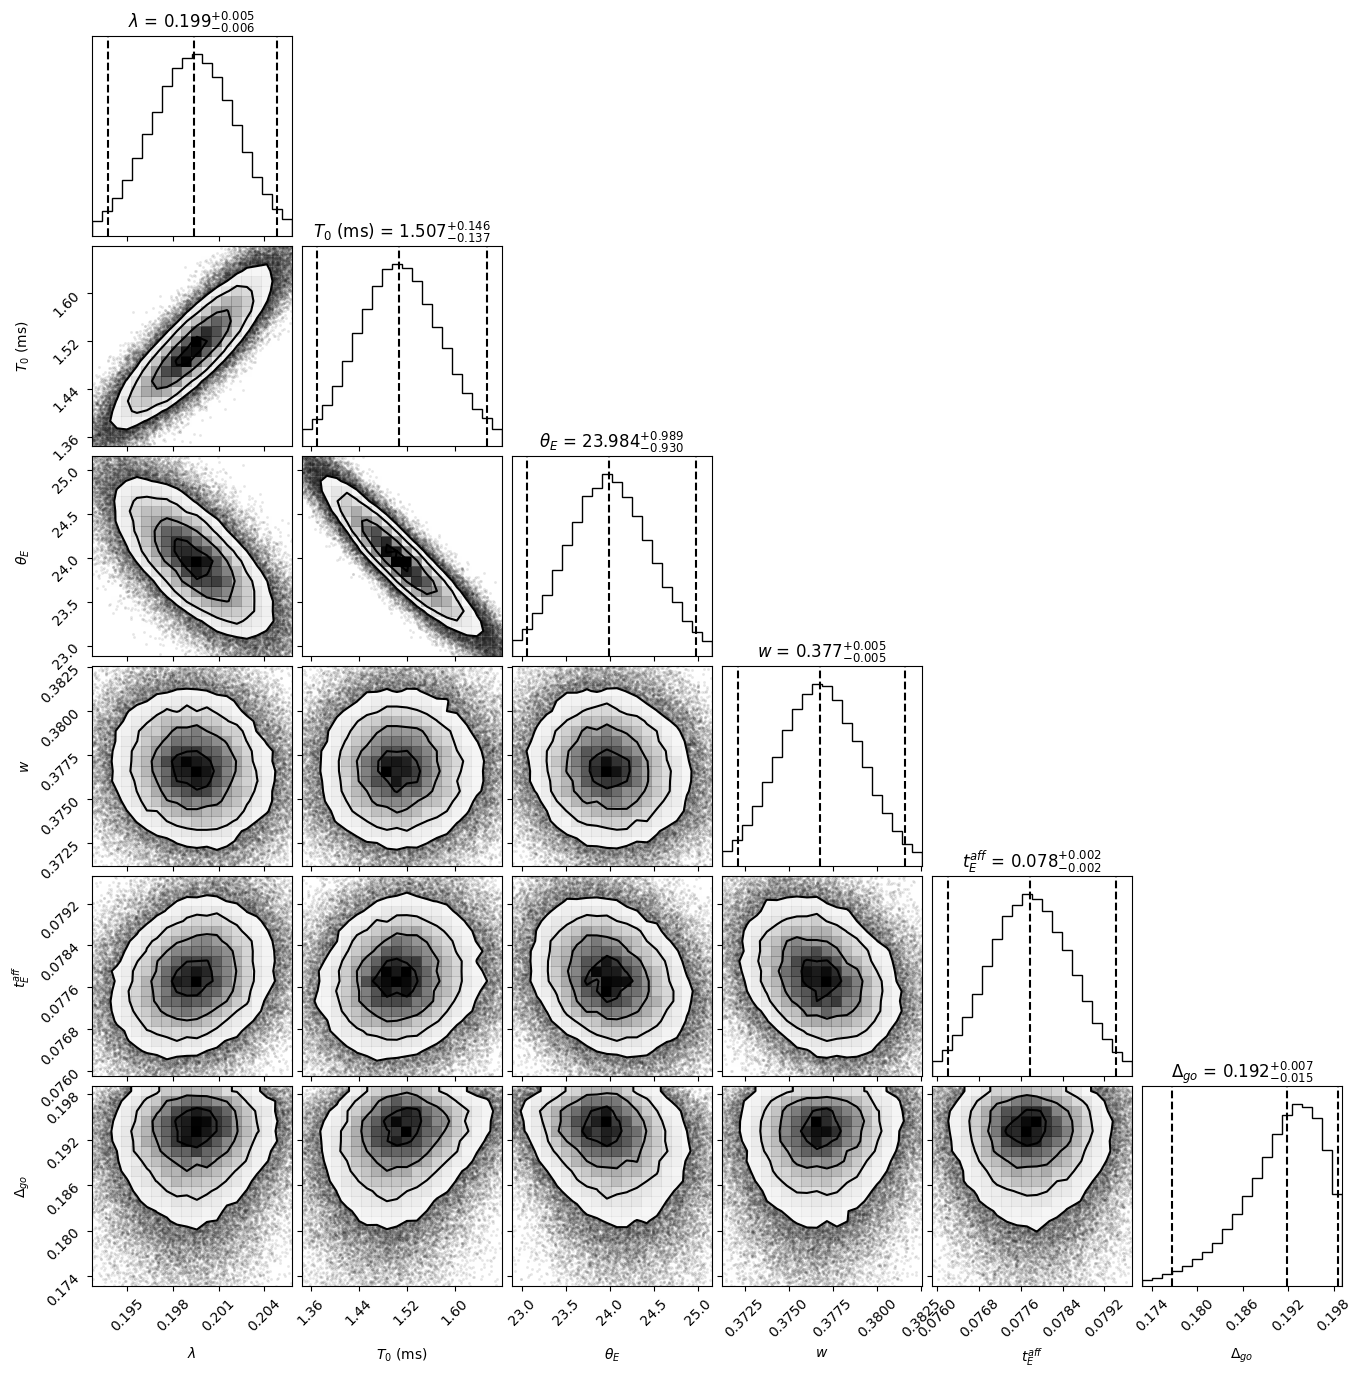

In [39]:
# Sample from the VBMC posterior (returns tuple: samples, log weights)
vp_samples = vp.sample(int(1e5))[0]

# Convert T_0 to ms (T_0 is at index 4)
vp_samples[:, 1] *= 1e3

# Parameter labels (order matters!)
param_labels = [
    r'$\lambda$',       # 3
    r'$T_0$ (ms)',      # 4
    r'$\theta_E$',      # 5
    r'$w$',             # 6
    r'$t_E^{aff}$',     # 7
    r'$\Delta_{go}$'    # 8
]

# Compute 1st and 99th percentiles for each param to restrict range
percentiles = np.percentile(vp_samples, [1, 99], axis=0)
_ranges = [(percentiles[0, i], percentiles[1, i]) for i in range(vp_samples.shape[1])]

# Create the corner plot
fig = corner.corner(
    vp_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
    title_fmt=".3f"
)

# Convert T_0 back to original units if needed
vp_samples[:, 1] /= 1e3

plt.show()

In [90]:
results['message'], results['elbo'], results['elbo_sd']

('Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.',
 6625.896956384019,
 0.0045446698200691475)

In [40]:
rate_lambda = vp_samples[:, 0].mean()
T_0 = vp_samples[:, 1].mean()
theta_E = vp_samples[:, 2].mean()
w = vp_samples[:, 3].mean()
Z_E = (w - 0.5) * 2 * theta_E
t_E_aff = vp_samples[:, 4].mean()
del_go = vp_samples[:, 5].mean()

# Print them out
print("Posterior Means:")
print(f"rate_lambda  = {rate_lambda:.5f}")
print(f"T_0 (ms)      = {1e3*T_0:.5f}")
print(f"theta_E       = {theta_E:.5f}")
print(f"Z_E           = {Z_E:.5f}")
print(f"t_E_aff       = {1e3*t_E_aff:.5f} ms")
print(f"del_go   = {del_go:.5f}")


Posterior Means:
rate_lambda  = 0.19933
T_0 (ms)      = 1.50869
theta_E       = 23.99281
Z_E           = -5.91249
t_E_aff       = 77.78948 ms
del_go   = 0.19071


In [47]:
# sample t-stim
N_sim = int(1e6)

t_stim_samples = df_all_trials_animal['intended_fix'].sample(N_sim, replace=True).values
ABL_samples = df_all_trials_animal['ABL'].sample(N_sim, replace=True).values
ILD_samples = df_all_trials_animal['ILD'].sample(N_sim, replace=True).values

N_print = int(N_sim / 5)
dt  = 1e-3

rate_norm_l = 0

sim_results = Parallel(n_jobs=30)(
    delayed(psiam_tied_data_gen_wrapper_rate_norm_fn)(
        V_A, theta_A, ABL_samples[iter_num], ILD_samples[iter_num], rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, del_go, 
        t_stim_samples[iter_num], rate_norm_l, iter_num, N_print, dt
    ) for iter_num in tqdm(range(N_sim))
)

os id: 15937, In iter_num: 0, ABL: 10, ILD: 8.0, t_stim: 0.267468069485527


 15%|█▍        | 148739/1000000 [02:18<13:15, 1070.67it/s]


os id: 15941, In iter_num: 200000, ABL: 55, ILD: 8.0, t_stim: 0.450434972823869


os id: 15955, In iter_num: 400000, ABL: 50, ILD: 1.25, t_stim: 0.264293637260745


os id: 15956, In iter_num: 600000, ABL: 10, ILD: -0.5, t_stim: 0.242255523241757


os id: 15941, In iter_num: 800000, ABL: 70, ILD: 1.25, t_stim: 0.357142400354734


100%|██████████| 1000000/1000000 [01:06<00:00, 14926.56it/s]


In [81]:
sim_results_df = pd.DataFrame(sim_results)
sim_results_df_valid = sim_results_df[
    (sim_results_df['rt'] > sim_results_df['t_stim']) &
    (sim_results_df['rt'] - sim_results_df['t_stim'] < 1)
].copy()
# sim_results_df_valid.loc[:, 'correct'] = (sim_results_df_valid['ILD'] * sim_results_df_valid['choice']).apply(lambda x: 1 if x > 0 else 0)
# ILD == 0, random choice
def correct_func(row):
    if row['ILD'] == 0:
        return np.random.choice([0, 1])
    return 1 if row['ILD'] * row['choice'] > 0 else 0

sim_results_df_valid.loc[:, 'correct'] = sim_results_df_valid.apply(correct_func, axis=1)

# remove correct column from df_valid_and_aborts
df_valid_animal_less_than_1_drop = df_valid_animal_less_than_1.copy().drop(columns=['correct']).copy()
df_valid_animal_less_than_1_drop.loc[:,'correct'] = df_valid_animal_less_than_1_drop.apply(correct_func, axis=1)
df_valid_animal_less_than_1_renamed = df_valid_animal_less_than_1_drop.rename(columns = {
    'TotalFixTime': 'rt',
    'intended_fix': 't_stim',
    # 'accuracy': 'correct'
}).copy()

sim_df_1 = sim_results_df_valid.copy()
data_df_1 = df_valid_animal_less_than_1_renamed.copy()

In [60]:
# theory
N_theory = int(1e3)
t_pts = np.arange(-1, 2, 0.001)
t_stim_samples = df_valid_and_aborts['intended_fix'].sample(N_theory, replace=True).values

P_A_samples = np.zeros((N_theory, len(t_pts)))
for idx, t_stim in enumerate(t_stim_samples):
    P_A_samples[idx, :] = [rho_A_t_fn(t + t_stim - t_A_aff, V_A, theta_A) for t in t_pts]

P_A_mean = np.mean(P_A_samples, axis=0)
C_A_mean = cumtrapz(P_A_mean, t_pts, initial=0)


/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


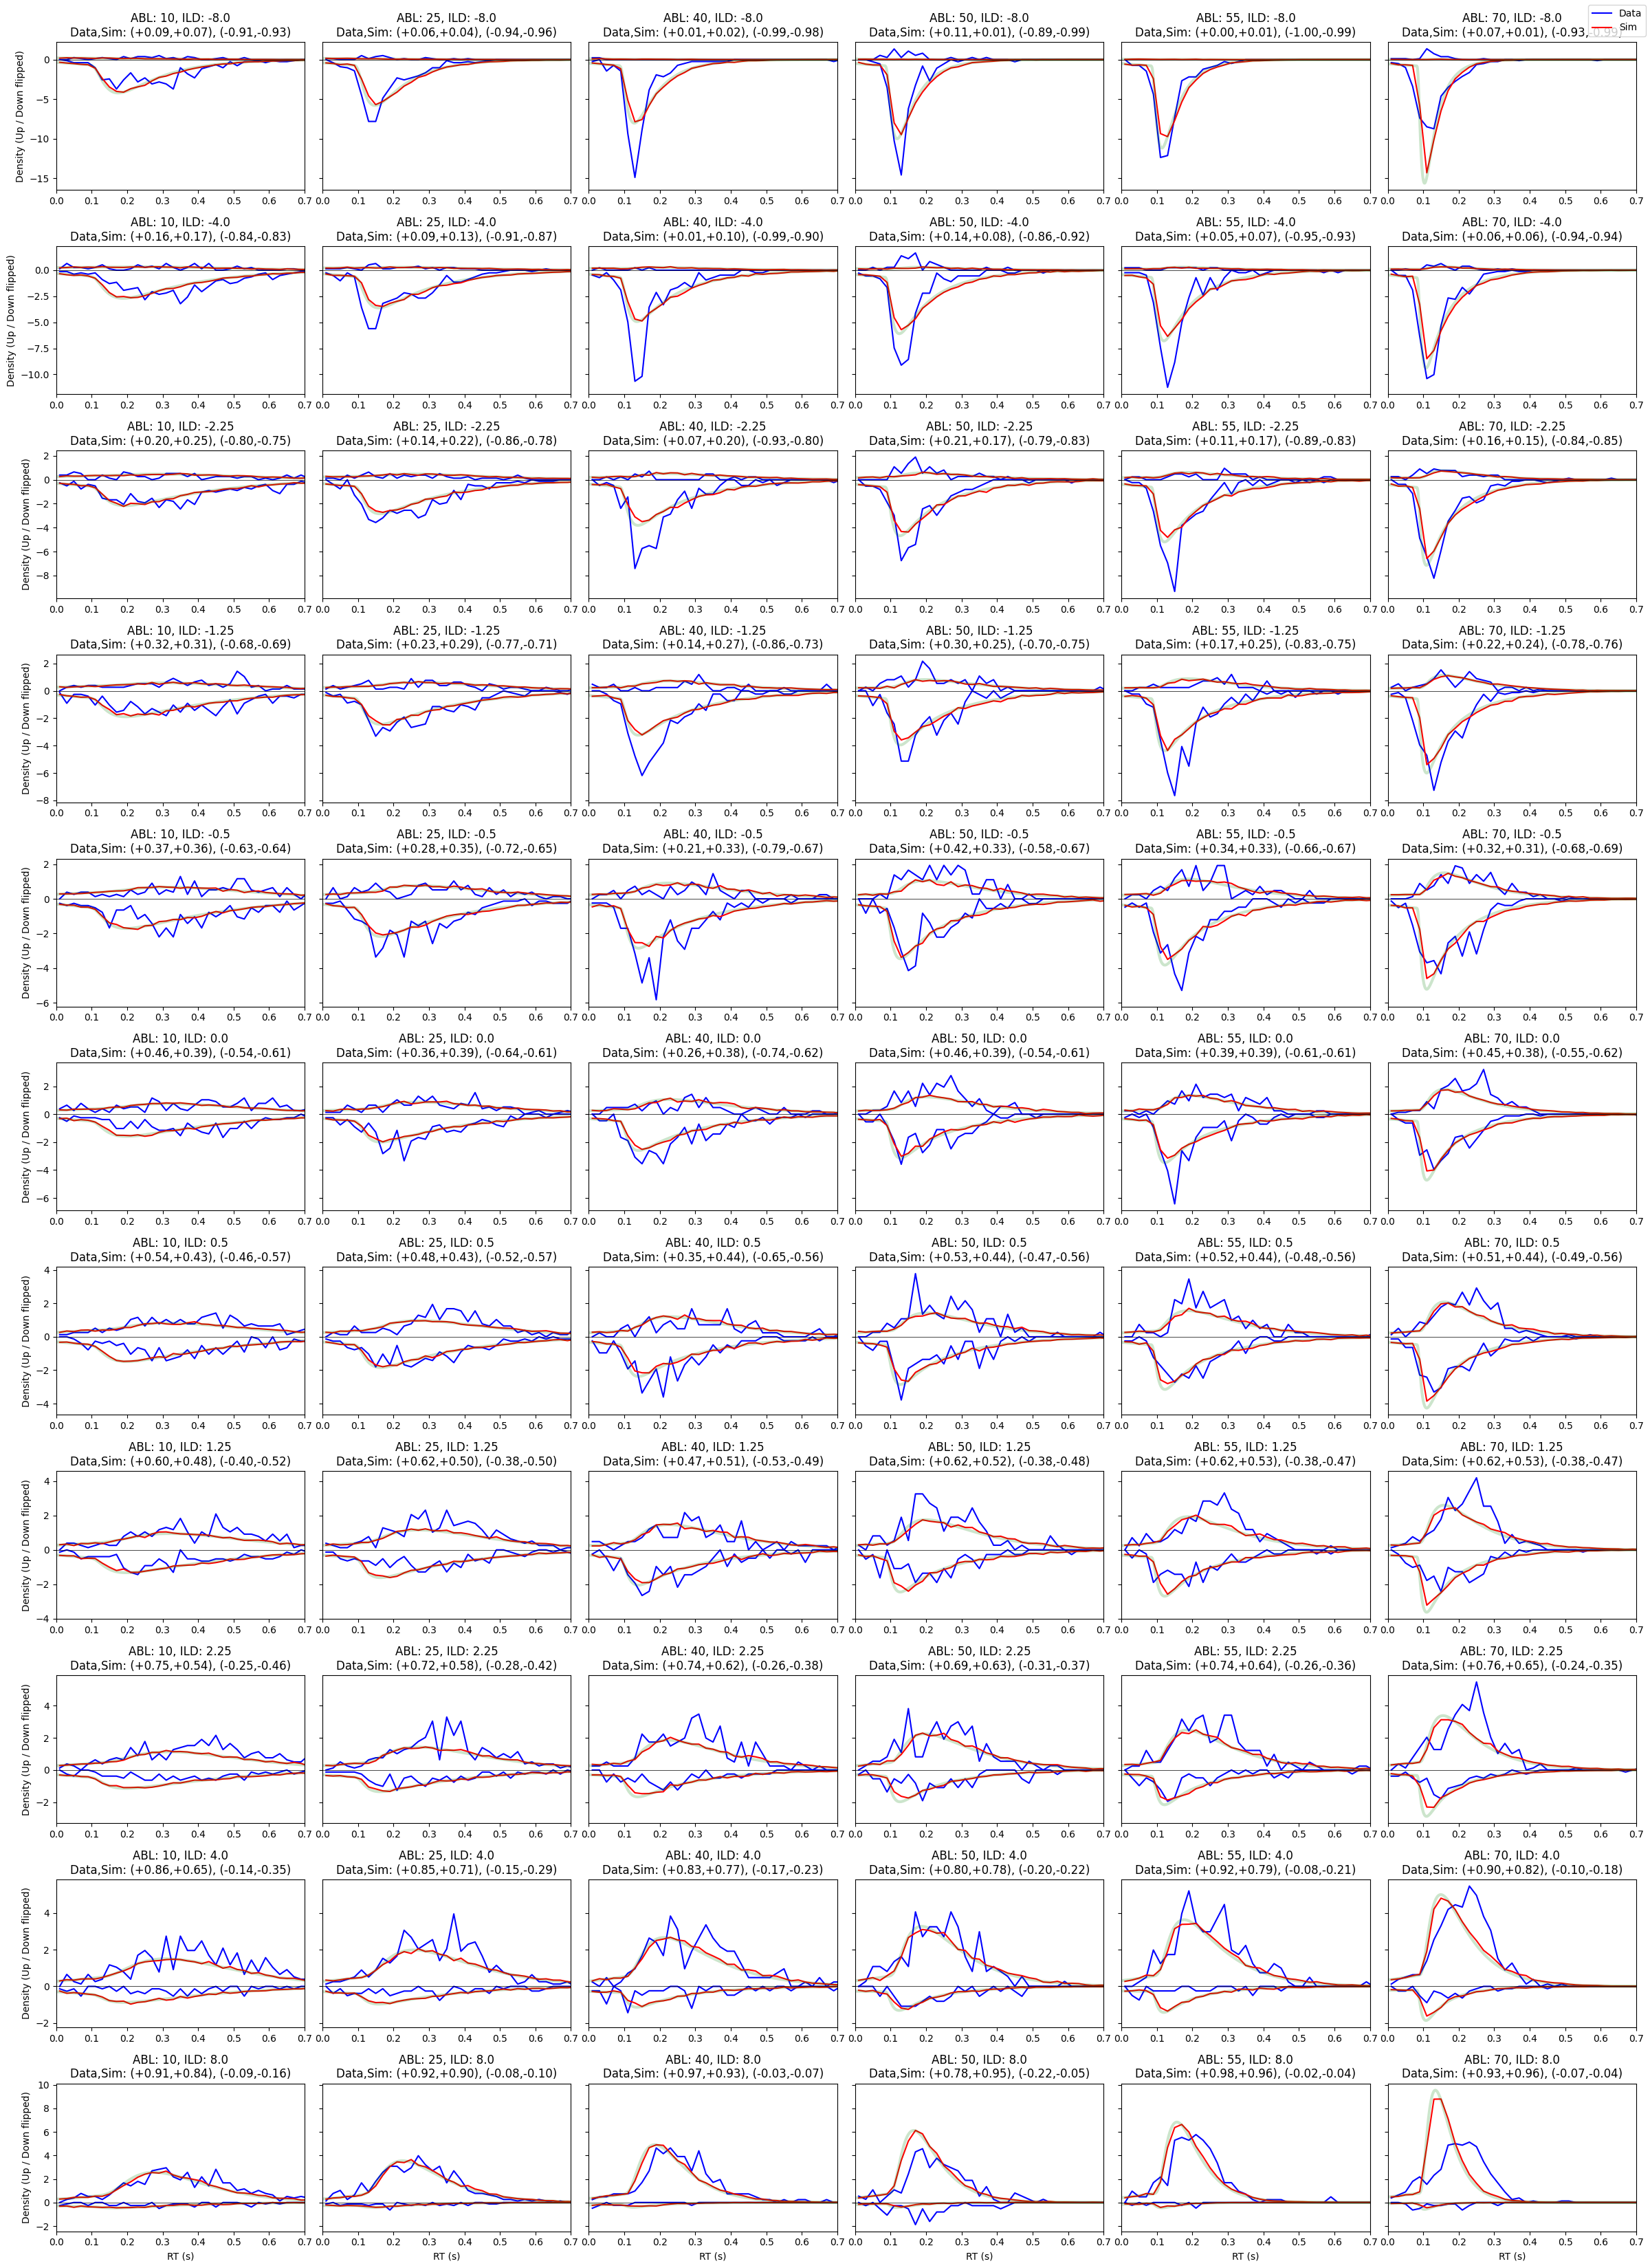

In [82]:
bw = 0.02
bins = np.arange(0, 1, bw)
bin_centers = bins[:-1] + (0.5 * bw)


n_rows = len(ILD_arr)
n_cols = len(ABL_arr)
theory_results_up_and_down = {} # Dictionary to store the theory results
theory_time_axis = None

fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharey='row')

for i_idx, ILD in enumerate(ILD_arr):
    for a_idx, ABL in enumerate(ABL_arr):
        ax = axs[i_idx, a_idx] if n_rows > 1 else axs[a_idx]

        sim_df_1_ABL_ILD = sim_df_1[(sim_df_1['ABL'] == ABL) & (sim_df_1['ILD'] == ILD)]
        data_df_1_ABL_ILD = data_df_1[(data_df_1['ABL'] == ABL) & (data_df_1['ILD'] == ILD)]

        sim_up = sim_df_1_ABL_ILD[sim_df_1_ABL_ILD['choice'] == 1]
        sim_down = sim_df_1_ABL_ILD[sim_df_1_ABL_ILD['choice'] == -1]
        data_up = data_df_1_ABL_ILD[data_df_1_ABL_ILD['choice'] == 1]
        data_down = data_df_1_ABL_ILD[data_df_1_ABL_ILD['choice'] == -1]

        sim_up_rt = sim_up['rt'] - sim_up['t_stim']
        sim_down_rt = sim_down['rt'] - sim_down['t_stim']
        data_up_rt = data_up['rt'] - data_up['t_stim']
        data_down_rt = data_down['rt'] - data_down['t_stim']

        sim_up_hist, _ = np.histogram(sim_up_rt, bins=bins, density=True)
        sim_down_hist, _ = np.histogram(sim_down_rt, bins=bins, density=True)
        data_up_hist, _ = np.histogram(data_up_rt, bins=bins, density=True)
        data_down_hist, _ = np.histogram(data_down_rt, bins=bins, density=True)

        # Normalize histograms by proportion of trials
        sim_up_hist *= len(sim_up) / len(sim_df_1_ABL_ILD)
        sim_down_hist *= len(sim_down) / len(sim_df_1_ABL_ILD)
        data_up_hist *= len(data_up) / len(data_df_1_ABL_ILD)
        data_down_hist *= len(data_down) / len(data_df_1_ABL_ILD)

        # theory
        trunc_fac_samples = np.zeros((N_theory))

        for idx, t_stim in enumerate(t_stim_samples):
            trunc_fac_samples[idx] = cum_pro_and_reactive_time_vary_fn(
                                t_stim + 1, proactive_trunc_time,
                                V_A, theta_A, t_A_aff,
                                t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                                phi_params_obj, rate_norm_l, 
                                is_norm, is_time_vary, K_max) \
                                - \
                                cum_pro_and_reactive_time_vary_fn(
                                t_stim,proactive_trunc_time,
                                V_A, theta_A, t_A_aff,
                                t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                                phi_params_obj, rate_norm_l, 
                                is_norm, is_time_vary, K_max) + 1e-10
        trunc_factor = np.mean(trunc_fac_samples)
        
        up_mean = np.array([up_or_down_RTs_fit_PA_C_A_given_wrt_t_stim_fn(
                    t, 1,
                    P_A_mean[i], C_A_mean[i],
                    ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                    phi_params_obj, rate_norm_l, 
                    is_norm, is_time_vary, K_max) for i, t in enumerate(t_pts)])
        down_mean = np.array([up_or_down_RTs_fit_PA_C_A_given_wrt_t_stim_fn(
                t, -1,
                P_A_mean[i], C_A_mean[i],
                ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                phi_params_obj, rate_norm_l, 
                is_norm, is_time_vary, K_max) for i, t in enumerate(t_pts)])
        
        mask_0_1      = (t_pts >= 0) & (t_pts <= 1)   # boolean index
        t_pts_0_1     = t_pts[mask_0_1]               # time vector you already made
        up_mean_0_1   = up_mean[mask_0_1]
        down_mean_0_1 = down_mean[mask_0_1]
        
        up_theory_mean_norm = up_mean_0_1 / trunc_factor
        down_theory_mean_norm = down_mean_0_1 / trunc_factor

        theory_results_up_and_down[(ABL, ILD)] = {'up': up_theory_mean_norm.copy(),
                                      'down': down_theory_mean_norm.copy()}
        if theory_time_axis is None: # Store time axis only once
             theory_time_axis = t_pts_0_1.copy()


        # Plot
        ax.plot(bin_centers, data_up_hist, color='b', label='Data' if (i_idx == 0 and a_idx == 0) else "")
        ax.plot(bin_centers, -data_down_hist, color='b')
        ax.plot(bin_centers, sim_up_hist, color='r', label='Sim' if (i_idx == 0 and a_idx == 0) else "")
        ax.plot(bin_centers, -sim_down_hist, color='r')

        ax.plot(t_pts_0_1, up_theory_mean_norm, lw=3, alpha=0.2, color='g')
        ax.plot(t_pts_0_1, -down_theory_mean_norm, lw=3, alpha=0.2, color='g')

        # Compute fractions
        data_total = len(data_df_1_ABL_ILD)
        sim_total = len(sim_df_1_ABL_ILD)
        data_up_frac = len(data_up) / data_total if data_total else 0
        data_down_frac = len(data_down) / data_total if data_total else 0
        sim_up_frac = len(sim_up) / sim_total if sim_total else 0
        sim_down_frac = len(sim_down) / sim_total if sim_total else 0

        ax.set_title(
            f"ABL: {ABL}, ILD: {ILD}\n"
            f"Data,Sim: (+{data_up_frac:.2f},+{sim_up_frac:.2f}), "
            f"(-{data_down_frac:.2f},-{sim_down_frac:.2f})"
        )
        
        ax.axhline(0, color='k', linewidth=0.5)
        ax.set_xlim([0, 0.7])
        if a_idx == 0:
            ax.set_ylabel("Density (Up / Down flipped)")
        if i_idx == n_rows - 1:
            ax.set_xlabel("RT (s)")

fig.tight_layout()
fig.legend(loc='upper right')
plt.show()


## tacho

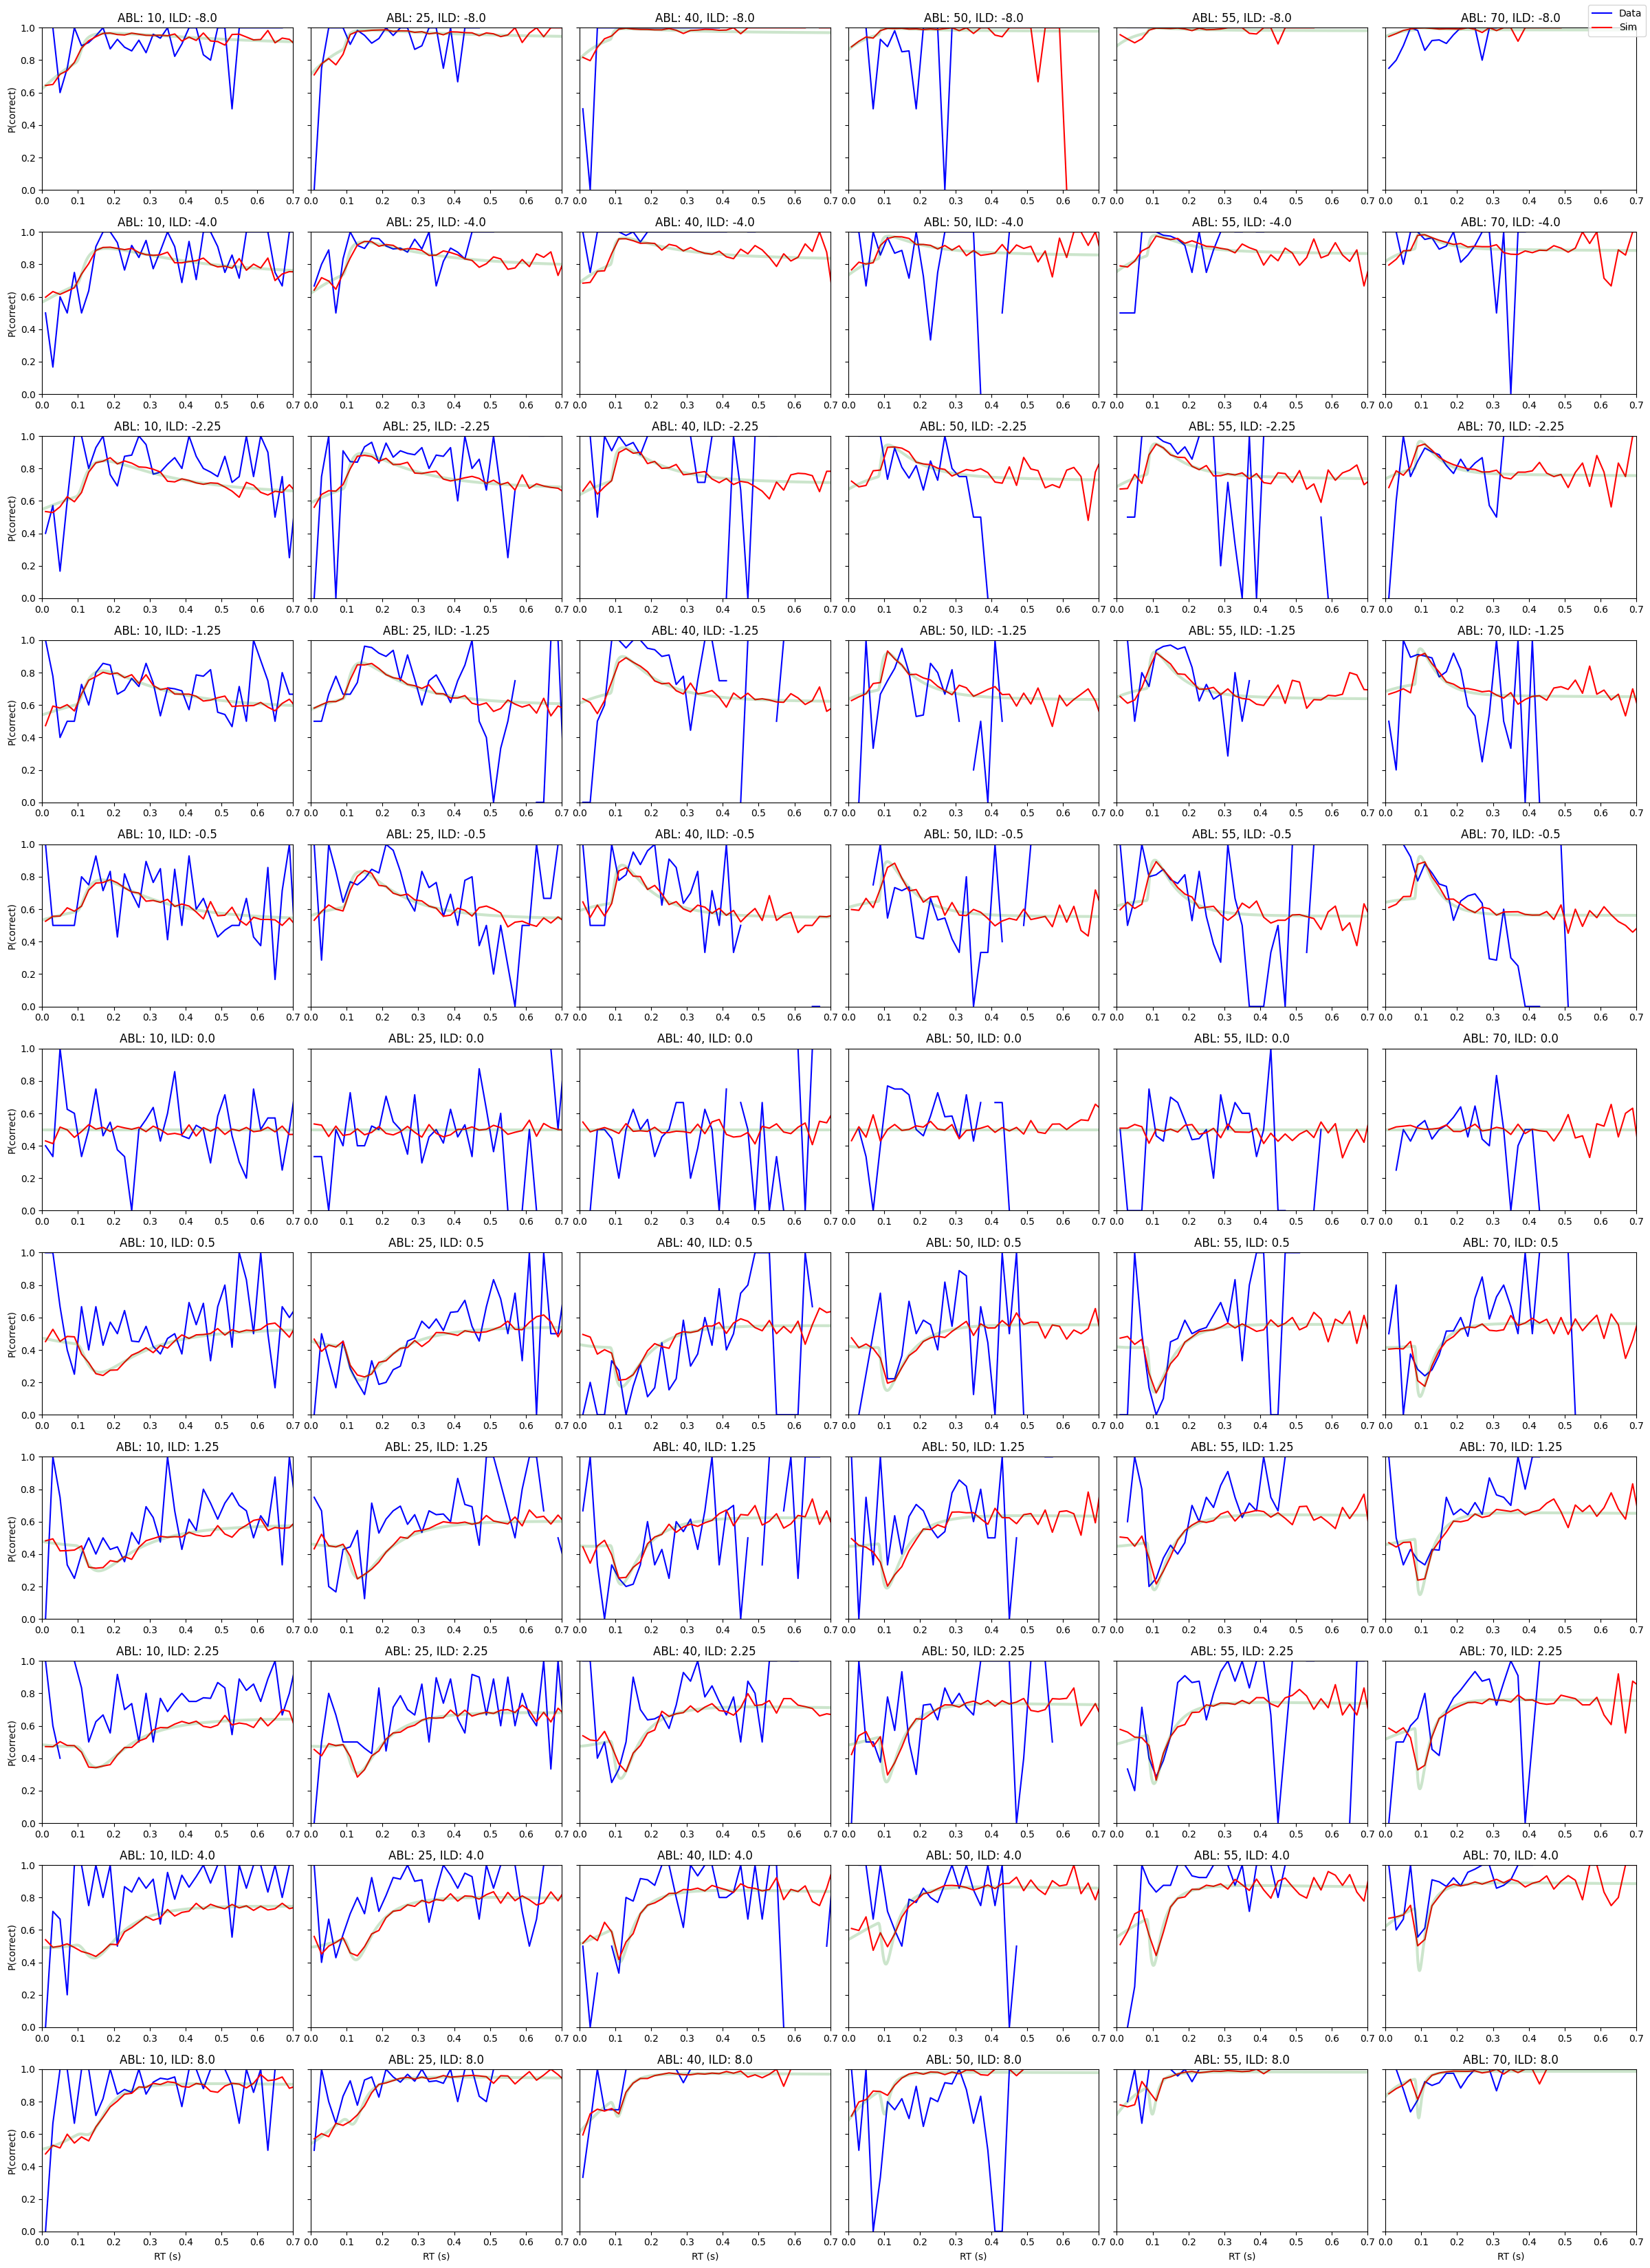

In [84]:
bw = 0.02
bins = np.arange(0, 1, bw)
bin_centers = bins[:-1] + (0.5 * bw)

def plot_tacho(df_1):
    df_1 = df_1.copy()
    df_1['RT_bin'] = pd.cut(df_1['rt'] - df_1['t_stim'], bins=bins, include_lowest=True)
    grouped = df_1.groupby('RT_bin', observed=False)['correct'].agg(['mean', 'count'])
    grouped['bin_mid'] = grouped.index.map(lambda x: x.mid)
    return grouped['bin_mid'], grouped['mean']
# ILD_arr_minus_zero = [x for x in ILD_arr if x != 0]

n_rows = len(ILD_arr)
n_cols = len(ABL_arr)

# === Define fig2 ===
fig2, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharey='row')

for i_idx, ILD in enumerate(ILD_arr):
    for a_idx, ABL in enumerate(ABL_arr):
        ax = axs[i_idx, a_idx] if n_rows > 1 else axs[a_idx]

        sim_df_1_ABL_ILD = sim_df_1[(sim_df_1['ABL'] == ABL) & (sim_df_1['ILD'] == ILD)]
        data_df_1_ABL_ILD = data_df_1[(data_df_1['ABL'] == ABL) & (data_df_1['ILD'] == ILD)]

        sim_tacho_x, sim_tacho_y = plot_tacho(sim_df_1_ABL_ILD)
        data_tacho_x, data_tacho_y = plot_tacho(data_df_1_ABL_ILD)

        # Plotting
        ax.plot(data_tacho_x, data_tacho_y, color='b', label='Data' if (i_idx == 0 and a_idx == 0) else "")
        ax.plot(sim_tacho_x, sim_tacho_y, color='r', label='Sim' if (i_idx == 0 and a_idx == 0) else "")

        up_theory_mean_norm = theory_results_up_and_down[(ABL, ILD)]['up']
        down_theory_mean_norm = theory_results_up_and_down[(ABL, ILD)]['down']
        if ILD > 0:
            ax.plot(t_pts_0_1, up_theory_mean_norm/(up_theory_mean_norm + down_theory_mean_norm), color='g', lw=3, alpha=0.2)
        elif ILD < 0:
            ax.plot(t_pts_0_1, down_theory_mean_norm/(up_theory_mean_norm + down_theory_mean_norm), color='g', lw=3, alpha=0.2)
        else:
            ax.plot(t_pts_0_1, 0.5*np.ones_like(t_pts_0_1), color='g', lw=3, alpha=0.2)

        ax.set_ylim([0, 1])
        ax.set_xlim([0, 0.7])
        ax.set_title(f"ABL: {ABL}, ILD: {ILD}")
        if a_idx == 0:
            ax.set_ylabel("P(correct)")
        if i_idx == n_rows - 1:
            ax.set_xlabel("RT (s)")

fig2.tight_layout()
fig2.legend(loc='upper right')
plt.show()


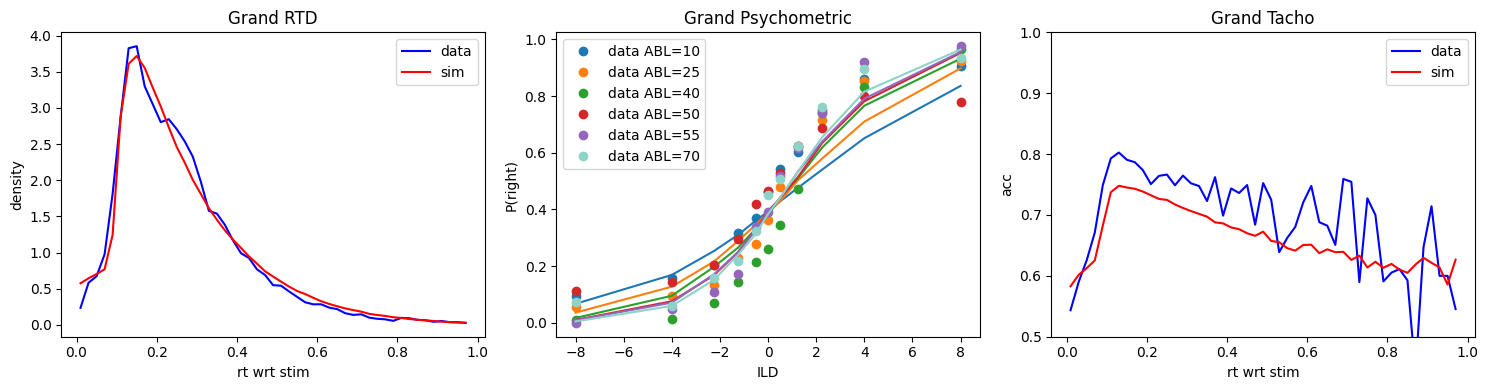

In [85]:
def grand_rtd(df_1):
    df_1_rt = df_1['rt'] - df_1['t_stim']
    rt_hist, _ = np.histogram(df_1_rt, bins=bins, density=True)
    return rt_hist

def plot_psycho(df_1):
    prob_choice_dict = {}

    all_ABL = np.sort(df_1['ABL'].unique())
    all_ILD = np.sort(ILD_arr)

    for abl in all_ABL:
        filtered_df = df_1[df_1['ABL'] == abl]
        prob_choice_dict[abl] = [
            sum(filtered_df[filtered_df['ILD'] == ild]['choice'] == 1) / len(filtered_df[filtered_df['ILD'] == ild])
            for ild in all_ILD
        ]

    return prob_choice_dict

# === Define fig3 ===
fig3, axes = plt.subplots(1, 3, figsize=(15, 4))

# === Grand RTD ===
axes[0].plot(bin_centers, grand_rtd(data_df_1), color='b', label='data')
axes[0].plot(bin_centers, grand_rtd(sim_df_1), color='r', label='sim')
axes[0].legend()
axes[0].set_xlabel('rt wrt stim')
axes[0].set_ylabel('density')
axes[0].set_title('Grand RTD')

# === Grand Psychometric ===
data_psycho = plot_psycho(data_df_1)
sim_psycho = plot_psycho(sim_df_1)

colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # muted green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8dd3c7',  # pale teal
    '#fdb462',  # burnt orange
    '#bcbd22',  # golden yellow
    '#17becf',  # bright blue
    '#9edae5',  # pale blue-green
]  # Define colors for each ABL
for i, ABL in enumerate(ABL_arr):
    axes[1].plot(ILD_arr, data_psycho[ABL], color=colors[i], label=f'data ABL={ABL}', marker='o', linestyle='None')
    axes[1].plot(ILD_arr, sim_psycho[ABL], color=colors[i], linestyle='-')

axes[1].legend()
axes[1].set_xlabel('ILD')
axes[1].set_ylabel('P(right)')
axes[1].set_title('Grand Psychometric')

# === Grand Tacho ===
data_tacho_x, data_tacho_y = plot_tacho(data_df_1)
sim_tacho_x, sim_tacho_y = plot_tacho(sim_df_1)

axes[2].plot(data_tacho_x, data_tacho_y, color='b', label='data')
axes[2].plot(sim_tacho_x, sim_tacho_y, color='r', label='sim')
axes[2].legend()
axes[2].set_xlabel('rt wrt stim')
axes[2].set_ylabel('acc')
axes[2].set_title('Grand Tacho')
axes[2].set_ylim(0.5, 1)

fig3.tight_layout()
plt.show()
